In [28]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output
import requests
import simplejson
from pandas.io.json import json_normalize
import warnings
warnings.filterwarnings('ignore')

In [35]:
def data_ingestion(url):
    r = requests.get(url)
    c = r.content
    j = simplejson.loads(c)
    data = json_normalize(j['rows'])
    
    return data
    


Reading the data from github
Thanks to [datameet](https://github.com/datameet) for gathering and consolidating the data


In [36]:
url = 'https://raw.githubusercontent.com/datameet/covid19/master/data/mohfw.json'
data = data_ingestion(url)

In [37]:
# mapping the state names
states = {}
states["Andhra Pradesh"]="AP"
states["Arunachal Pradesh"]="AR"
states["Assam"]="AS"
states["Bihar"]="BR"
states["Chandigarh"]="CH"
states["Chhattisgarh"]="CT"
states["Goa"]="GA"
states["Gujarat"]="GJ"
states["Haryana"]="HR"
states["Himachal Pradesh"]="HP"
states["Jharkhand"]="JH"
states["Karnataka"]="KA"
states["Kerala"]="KL"
states["Madhya Pradesh"]="MP"
states["Maharashtra"]="MH"
states["Manipur"]="MN"
states["Meghalaya"]="ML"
states["Mizoram"]="MZ"
states["Nagaland"]="NL"
states["Odisha"]="OR"
states["Punjab"]="PB"
states["Rajasthan"]="RJ"
states["Sikkim"]="SK"
states["Tamil Nadu"]="TN"
states["Telengana"]="TG"
states["Tripura"]="TR"
states["Uttarakhand"]="UT"
states["Uttar Pradesh"]="UP"
states["West Bengal"]="WB"
states["Andaman and Nicobar Islands"]="AN"
states["Dadra and Nagar Haveli"]="DN"
states["Daman and Diu"]="DD"
states["Delhi"]="DL"
states["Jammu and Kashmir"]="JK"
states["Ladakh"]="LA"
states["Lakshadweep"]="LD"
states["Puducherry"]="PY"
states = {v: k for k, v in states.items()}

In [38]:
def data_cleaning(data):
    
    # filtering the relevant columns
    cols =  [i for i in data.columns if 'value' in i]
    data = data[cols]
    s = [str(i).split(".",1)[1] for i in data.columns]
    data.columns = s
    # converting to datetime function
    data['report_time'] = pd.to_datetime(data['report_time'])
    
    #converting to string
    data['state'] = data['state'].astype(str)
    
    #adding a date column
    data['date_report_time'] = [i.date() for i in data['report_time']]
    return data
    
    
def get_state_names(states,data):
    
    """
    Parameters
    ----------
    
    States : it is a dictionary 
    data : dataframe object
    
    """
    
    data['state'] = data['state'].str.upper()
    data['state_names'] = (data['state']).map(states)
    return(data)
    

    
data = data_cleaning(data)
data = get_state_names(states,data)

In [39]:
data.head()

,_id,_rev,report_time,state,confirmed_india,confirmed_foreign,cured,death,source,type,confirmed,date_report_time,state_names
0,2020-01-30T13:33:00.00+05:30|kl,2-727ff11254cdb1c043ab19b2714b3cab,2020-01-30 13:33:00+05:30,KL,1.0,0.0,0,0,mohfw_pib,cases,1,2020-01-30,Kerala
1,2020-02-02T10:39:00.00+05:30|kl,2-243204a6ebc85f1e9a48a597b1b601fc,2020-02-02 10:39:00+05:30,KL,2.0,0.0,0,0,mohfw_pib,cases,2,2020-02-02,Kerala
2,2020-02-03T12:13:00.00+05:30|kl,2-9f86f235a4ae4bd939d88f900857cad3,2020-02-03 12:13:00+05:30,KL,3.0,0.0,0,0,mohfw_pib,cases,3,2020-02-03,Kerala
3,2020-03-02T14:28:00.00+05:30|dl,2-21817e9568a28f7cf57f756d56bbfaf1,2020-03-02 14:28:00+05:30,DL,1.0,0.0,0,0,mohfw_pib,cases,1,2020-03-02,Delhi
4,2020-03-02T14:28:00.00+05:30|kl,2-6a1212defbdcc4666f0dca6d40dd0451,2020-03-02 14:28:00+05:30,KL,3.0,0.0,0,0,mohfw_pib,cases,3,2020-03-02,Kerala


In [40]:
# getting the latest record per day 

df = data.sort_values(by="report_time").drop_duplicates(subset=['date_report_time','state'], keep="last")

# selecting required columns
states = df[['date_report_time','state_names','confirmed']]

# resetting the index
states = states.set_index(['state_names','date_report_time'])

states = states.sort_index()
states = states.squeeze()

    

# Calculation of Rt 

I have implemented the same flow which was adoopted by the [Kevin Systrom](https://github.com/k-sys)
<br> All credits to him and his team

# Why  Estimating COVID-19's $R_t$ is important?


In any pandemic, $R_t$ is the measure known as the effective reproduction number. It's the number of people who become infected per infectious person at time $t$. The most well-known version of this number is the basic reproduction number: $R_0$ when $t=0$. However, $R_0$ is a single measure that does not adapt with changes in behavior and restrictions.

As a pandemic evolves, increasing restrictions (or potential releasing of restrictions) changes $R_t$. Knowing the current $R_t$ is essential. When $R\gg1$, the pandemic will spread through a large part of the population. If $R_t$<$1$, the pandemic will slow quickly before it has a chance to infect many people. The lower the $R_t$: the more manageable the situation. In general, any $R_t$<$1$ means things are under control.

In [41]:
def prepare_cases(cases):
    new_cases = cases.diff()
    #print(new_cases)
    smoothed = new_cases.rolling(9,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=3).round()
    
    idx_start = np.searchsorted(smoothed, 10)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

In [42]:
def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=[f'Low_{p*100:.0f}', f'High_{p*100:.0f}'])

In [43]:
def plot_rt(result, ax, state_names):
    
    ax.set_title(f"{state_names}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date_report_time')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date_report_time')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')




In [44]:
FILTERED_REGION_CODES = ['Andhra Pradesh',
 'Assam',
 'Bihar',
 'Chandigarh',
 'Chhattisgarh',
 'Goa',
 'Gujarat',
 'Haryana',
 'Himachal Pradesh',
 'Jharkhand',
 'Karnataka',
 'Kerala',
 'Madhya Pradesh',
 'Maharashtra',
 'Manipur',
 'Meghalaya',
 'Mizoram',
 'Nagaland',
 'Odisha',
 'Punjab',
 'Rajasthan',
 'Sikkim',
 'Tamil Nadu',
 'Telengana',
 'Tripura',
 'Uttarakhand',
 'Uttar Pradesh',
 'West Bengal',
 'Dadra and Nagar Haveli',
 'Daman and Diu',
 'Delhi',
 'Jammu and Kashmir',
 'Ladakh',
 'Lakshadweep',
 'Puducherry']

In [46]:
GAMMA = 1/7
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)
def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

In [47]:
sigmas = np.linspace(1/20, 1, 20)

targets = states.index.get_level_values('state_names').isin(FILTERED_REGION_CODES)
states_to_process = states.loc[targets]

results = {}

for state_name, cases in states_to_process.groupby(level='state_names'):
    
    print(state_name)
    cases = states.xs(state_name)
    new, smoothed = prepare_cases(cases)
    if len(smoothed) != 0:
        result = {}

        # Holds all posteriors with every given value of sigma
        result['posteriors'] = []

        # Holds the log likelihood across all k for each value of sigma
        result['log_likelihoods'] = []

        for sigma in sigmas:
            posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
            result['posteriors'].append(posteriors)
            result['log_likelihoods'].append(log_likelihood)

        # Store all results keyed off of state name
        results[state_name] = result
        clear_output(wait=True)

print('Done.')

Done.


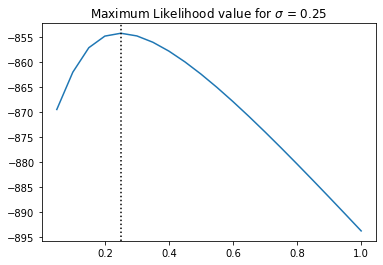

In [48]:
# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each state's results and add the log likelihoods to the running total.
for state_name, result in results.items():
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]

# Plot it
fig, ax = plt.subplots()
ax.set_title(f"Maximum Likelihood value for $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, total_log_likelihoods)
ax.axvline(sigma, color='k', linestyle=":")

# Final Results


Implemented Parallel processing as the below task was taking lot of time

In [49]:
from joblib import Parallel, delayed
import time
def run_parallel(state_name,result):
    start = time.time()
    posteriors = result['posteriors'][max_likelihood_index]
    hdis_90 = highest_density_interval(posteriors, p=.9)
    hdis_50 = highest_density_interval(posteriors, p=.5)
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
    result['state'] = state_name
    print("Total time{} sec".format(time.time()-start))
    return result

In [50]:
final_results = Parallel(n_jobs=-1,verbose=10)(delayed(run_parallel) (state_name,result) for state_name, result in results.items())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   23.0s remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   24.5s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   25.5s remaining:   38.3s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   35.1s remaining:   30.7s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   37.0s remaining:   18.4s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   41.6s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   42.5s finished


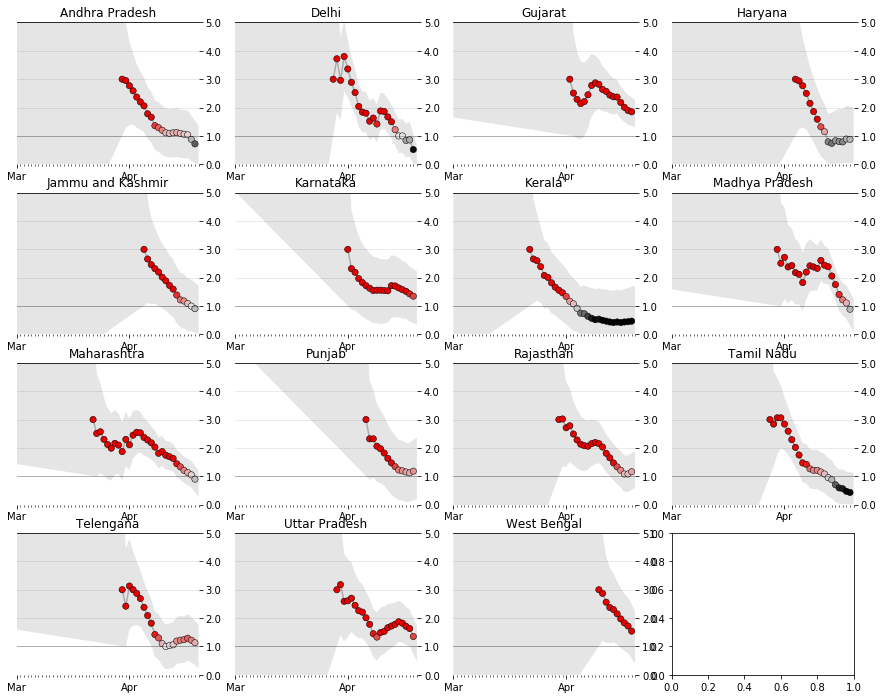

In [52]:
ncols = 4
nrows = int(np.ceil(len(results) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i in range(len(final_results)):
    result = final_results[i]
    plot_rt(result,axes.flat[i],result['state'].tail(1).values[0])

In [53]:
fig.savefig('Rt_score.png')

In [55]:
# converting a list into dataframe
final_results1 = None
for i in range(len(final_results)):
    result = final_results[i]
    if final_results1 is None:
        final_results1 = result
    else:
        final_results1 = pd.concat([final_results1, result])
    

In [57]:
final_results1.to_csv('final_results.csv')